In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
sys.path.append("../../")
import spacy
from src.loader import TextLoader
from src.purifier import Purifier
from tqdm import tqdm
from pathlib import Path
import torch
from torch import nn
from transformers import RobertaTokenizer
from transformers import RobertaModel
import wandb

c:\Users\Jurek\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#wandb.init(project="discourse-classification", entity="evaluating-student-writing", name="Roberta_classification_short_1")

In [2]:
def count_label(df, labels):
    label_count_dict = {}
    labeled_df_dict = {}
    for label in labels:
        label_df = df[df['discourse_type']==label]
        label_count_dict[label] = len(label_df)
        labeled_df_dict[label] = label_df
    return label_count_dict, labeled_df_dict

def oversampling(df, labels, amount_for_class = 1000):
    new_df = pd.DataFrame()
    label_count, labeled_df_dict = count_label(df, labels)
    print(label_count)
    for label, count in label_count.items():
        print(label)
        lb_df = labeled_df_dict[label]
        if count < amount_for_class:
            while len(lb_df) < amount_for_class:
                row = labeled_df_dict[label].sample()
                lb_df = pd.concat([lb_df, row])
                #lb_df.loc[len(new_df)] = [row.values[0][0], row.values[0][1]]
        new_df = pd.concat([new_df, lb_df])
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

def undersampling(df, labels, amount_for_class = 1000):
    new_df = pd.DataFrame()
    label_count, labeled_df_dict = count_label(df, labels)
    for label, count in label_count.items():
        lb_df = pd.DataFrame()
        if count < amount_for_class:
            lb_df = labeled_df_dict[label]
            new_df = pd.concat([new_df, lb_df])
        else:
            while len(lb_df) < amount_for_class:
                row = labeled_df_dict[label].sample()
                lb_df = pd.concat([lb_df, row])
            new_df = pd.concat([new_df, lb_df])
    return new_df

In [3]:
module_path = Path.cwd().parent.parent
if module_path not in sys.path:
    sys.path.insert(0, str(module_path))

In [12]:
path = Path(module_path / "data" / "train_v1_no_predictionstring.xz")
data = pd.read_csv(path, compression="xz")
data = data[["discourse_text", "discourse_type"]]
data.head()

,discourse_text,discourse_type
0,Modern humans today are always on their phone....,Lead
1,They are some really bad consequences when stu...,Position
2,Some certain areas in the United States ban ph...,Evidence
3,When people have phones they know about certai...,Evidence
4,Driving is one of the way how to get around. P...,Claim


In [13]:
count_label(data, ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal'])

({'Lead': 9303,
  'Position': 15415,
  'Evidence': 45691,
  'Claim': 50197,
  'Concluding Statement': 13503,
  'Counterclaim': 5813,
  'Rebuttal': 4334},
 {'Lead':                                            discourse_text discourse_type
  0       Modern humans today are always on their phone....           Lead
  14      The ability to stay connected to people we kno...           Lead
  21      People are debating whether if drivers should ...           Lead
  33      Over half of drivers in today's society have t...           Lead
  42      Being on your device and driving could be an o...           Lead
  ...                                                   ...            ...
  144203  Do you ever want more opinions and options whe...           Lead
  144215  Has anyone ever gave you advice Was the advice...           Lead
  144224  Imagine seeking advice from multiple people an...           Lead
  144233  There has been at least one point in everyone'...           Lead
  144247  In 

In [14]:
data = undersampling(data, ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal'], 15000)

In [15]:
labels = {'Lead':0,
          'Position':1,
          'Evidence':2,
          'Claim':3,
          'Concluding Statement':4,
          'Counterclaim':5, 
          'Rebuttal':6
}

In [16]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [17]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['discourse_type']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['discourse_text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [18]:
from sklearn.model_selection import train_test_split
np.random.seed(2137)
df_train, df_test = train_test_split(data, test_size=0.08)
df_val, df_test = train_test_split(df_test, test_size=0.25)

In [19]:
print(len(df_train),len(df_val), len(df_test))

71716 4677 1560


In [11]:
#df_train = undersampling(df_train, ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal'], 15000)

In [20]:
count_label(df_train, ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal'])

({'Lead': 8557,
  'Position': 13735,
  'Evidence': 13794,
  'Claim': 13873,
  'Concluding Statement': 12422,
  'Counterclaim': 5331,
  'Rebuttal': 4004},
 {'Lead':                                            discourse_text discourse_type
  55583   In the article Unmasking the Face on Mars NASA...           Lead
  85644   Driverless cars are not science fiction and th...           Lead
  15484   Every year students look forward to going on s...           Lead
  30459   Many schools have all sorts of extracurricular...           Lead
  120506  Most students across the world usually receive...           Lead
  ...                                                   ...            ...
  133052  Palms sweating someone starts pacing the room ...           Lead
  23782   Schools claim that they are preparing their st...           Lead
  123205  Schooling has been around for thousands of yea...           Lead
  46774   Technology may be a problem for other occasion...           Lead
  108908  Cel

In [14]:
#df_test = undersampling(df_test, ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal'], 200)

In [21]:
count_label(df_test, ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal'])

({'Lead': 173,
  'Position': 330,
  'Evidence': 289,
  'Claim': 268,
  'Concluding Statement': 303,
  'Counterclaim': 113,
  'Rebuttal': 84},
 {'Lead':                                            discourse_text discourse_type
  18014   Work assigned over the summer is very much dre...           Lead
  115045  Every school situation is different when it co...           Lead
  79921   People say that technology is forever chaging ...           Lead
  135927                   Why talk to more than one person           Lead
  19869   Summer projects designed by teachers can boost...           Lead
  ...                                                   ...            ...
  67162   I just heard of your plan to make community se...           Lead
  128725  The schools offer is option that the students ...           Lead
  59967   Imagine you are a scientist at NASA sicussing ...           Lead
  132736  Have you struggled and asked someone to help P...           Lead
  108598  Ring Ring Ring.

In [22]:
print(len(df_train),len(df_val), len(df_test))

71716 4677 1560


In [23]:
class RobertaClassifier(nn.Module):

    def __init__(self, dropout=0.4):

        super(RobertaClassifier, self).__init__()

        self.bert = RobertaModel.from_pretrained('roberta-base')
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 256)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(256, 64)
        self.dropout3 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(64, 7)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
        dropout1_output = self.dropout1(pooled_output)
        linear1_output = self.linear1(dropout1_output)
        dropout2_output = self.dropout2(linear1_output)
        linear2_output = self.linear2(dropout2_output)
        dropout3_output = self.dropout3(linear2_output)
        linear3_output = self.linear3(dropout3_output)
        final_layer = self.relu(linear3_output)

        return final_layer

In [14]:
class RobertaClassifierShort(nn.Module):

    def __init__(self, dropout=0.4):

        super(RobertaClassifierShort, self).__init__()

        self.bert = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 7)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [24]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    print(use_cuda)
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    
    optimizer = Adam(model.parameters(), lr= learning_rate)
    

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [25]:
                  
EPOCHS = 5
model = RobertaClassifier()
LR = 1e-5
#wandb.watch(model, log='all', log_freq=100)
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


True


100%|██████████| 8965/8965 [40:35<00:00,  3.68it/s]


Epochs: 1 | Train Loss:  0.113                 | Train Accuracy:  0.710                 | Val Loss:  0.096                 | Val Accuracy:  0.761


100%|██████████| 8965/8965 [34:18<00:00,  4.36it/s]


Epochs: 2 | Train Loss:  0.074                 | Train Accuracy:  0.819                 | Val Loss:  0.093                 | Val Accuracy:  0.773


100%|██████████| 8965/8965 [32:16<00:00,  4.63it/s]


Epochs: 3 | Train Loss:  0.047                 | Train Accuracy:  0.891                 | Val Loss:  0.092                 | Val Accuracy:  0.787


100%|██████████| 8965/8965 [32:45<00:00,  4.56it/s]


Epochs: 4 | Train Loss:  0.029                 | Train Accuracy:  0.936                 | Val Loss:  0.099                 | Val Accuracy:  0.792


100%|██████████| 8965/8965 [33:51<00:00,  4.41it/s]


Epochs: 5 | Train Loss:  0.021                 | Train Accuracy:  0.956                 | Val Loss:  0.116                 | Val Accuracy:  0.781


In [13]:
#the_model = torch.load("roberta_classifier_model_first")

In [14]:
# import time
# torch.save(model.state_dict(), f"roberta_classifier_short_model_5_epochs_2_state_dict")

In [26]:

torch.save(model, f"roberta_classifier_short_model_5_epochs_1_undersampling")

In [27]:
wyniki = []
y_t = []

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              wyniki.append(output.argmax(dim=1))
              y_t.append(test_label)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.788


In [28]:
y_pred = []
for t in wyniki:
    for b in t:
        y_pred.append(int(b))
y_true = []
for t in y_t:
    for b in t:
        y_true.append(int(b))

In [29]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

weighted 0.787980865126366
micro 0.7884615384615384
macro 0.7715983840733361
matthews_corrcoef 0.7458229221962597


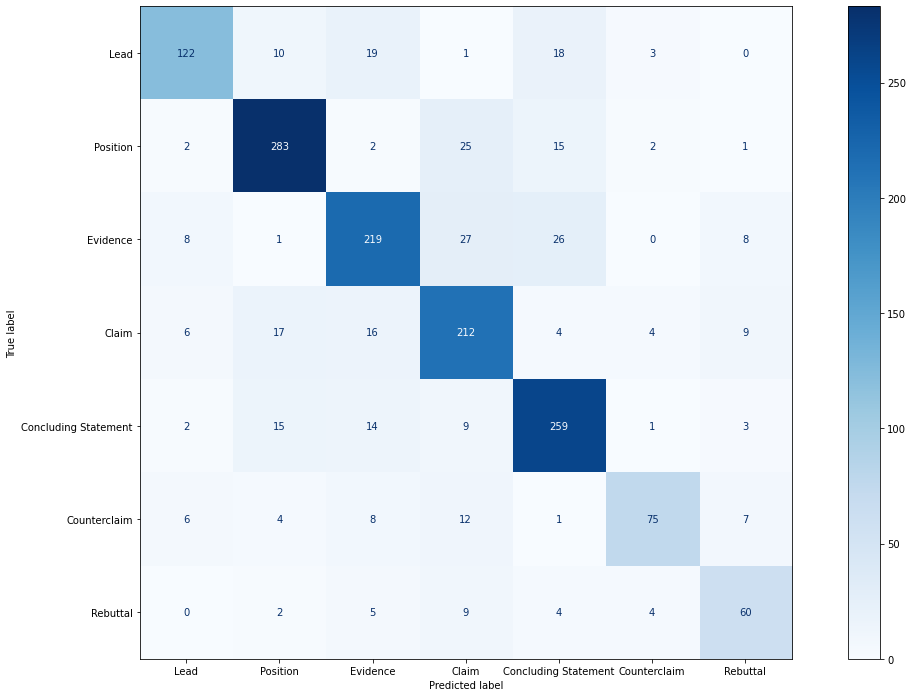

In [30]:
print('weighted', f1_score(y_true, y_pred, average='weighted'))
print('micro', f1_score(y_true, y_pred, average='micro'))
print('macro', f1_score(y_true, y_pred, average='macro'))
print('matthews_corrcoef', matthews_corrcoef(y_true, y_pred))

fig = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                               labels=[0,1,2,3,4,5,6], 
                                               display_labels = ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement','Counterclaim', 'Rebuttal'],
                                               cmap=plt.cm.Blues,
                                               )
fig = fig.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(12)